In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib

In [2]:
df = pd.read_csv('dataset/flood.csv')
df.head()

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
0,3,8,6,6,4,4,6,2,3,2,...,10,7,4,2,3,4,3,2,6,0.450
1,8,4,5,7,7,9,1,5,5,4,...,9,2,6,2,1,1,9,1,3,0.475
2,3,10,4,1,7,5,4,7,4,9,...,7,4,4,8,6,1,8,3,6,0.515
3,4,4,2,7,3,4,1,4,6,4,...,4,2,6,6,8,8,6,6,10,0.520
4,3,7,5,2,5,8,5,2,7,5,...,7,6,5,3,3,4,4,3,4,0.475


In [3]:
# checking if there null data
print(df.isnull().sum())

MonsoonIntensity                   0
TopographyDrainage                 0
RiverManagement                    0
Deforestation                      0
Urbanization                       0
ClimateChange                      0
DamsQuality                        0
Siltation                          0
AgriculturalPractices              0
Encroachments                      0
IneffectiveDisasterPreparedness    0
DrainageSystems                    0
CoastalVulnerability               0
Landslides                         0
Watersheds                         0
DeterioratingInfrastructure        0
PopulationScore                    0
WetlandLoss                        0
InadequatePlanning                 0
PoliticalFactors                   0
FloodProbability                   0
dtype: int64


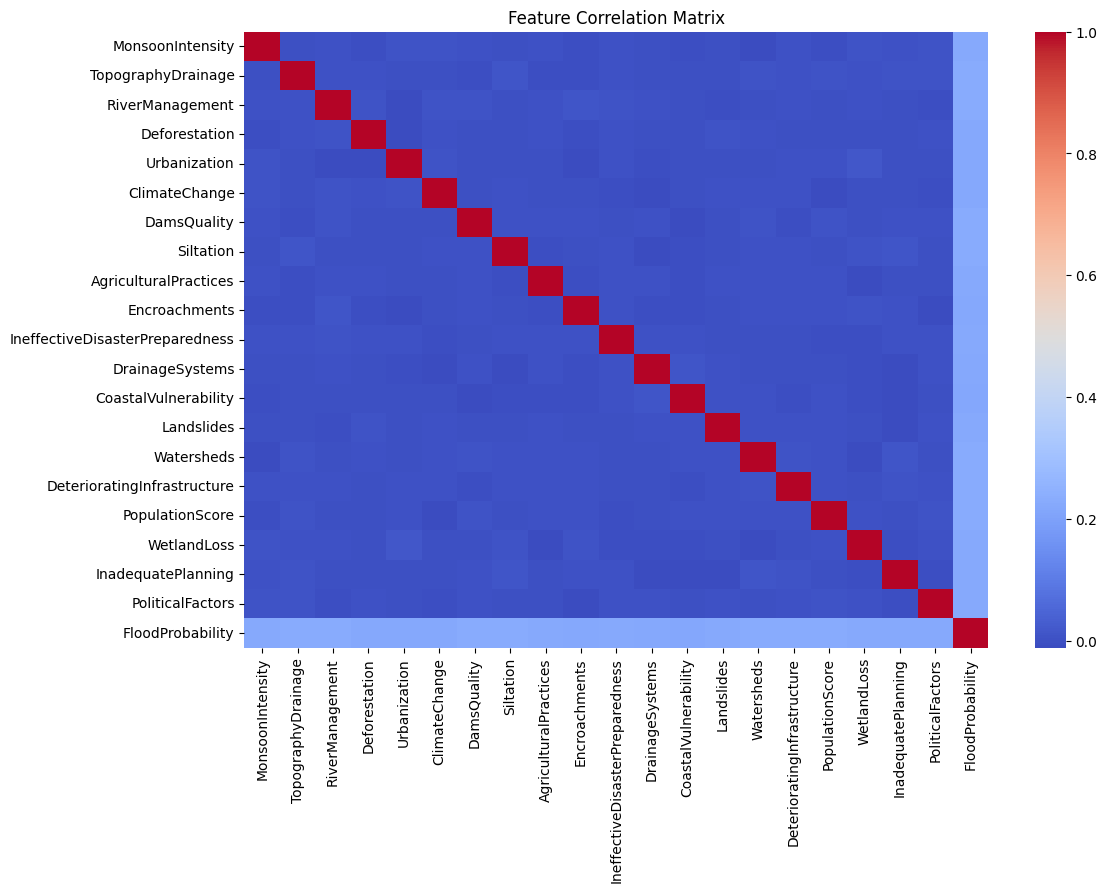

In [4]:
# Correlation matrix
plt.figure(figsize=(12, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

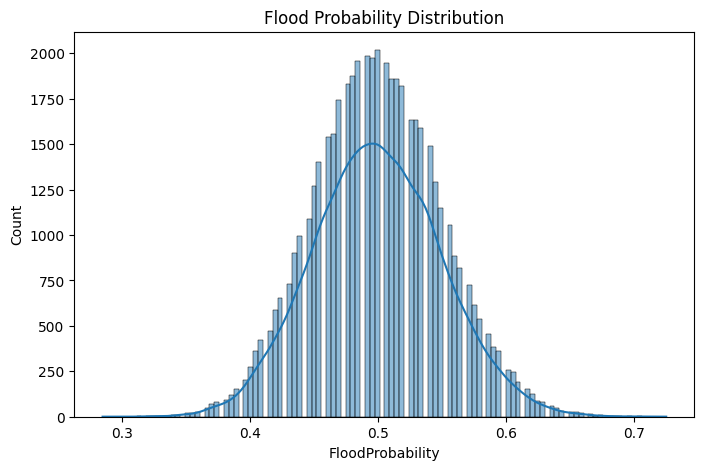

In [5]:
plt.figure(figsize=(8, 5))
sns.histplot(df['FloodProbability'], kde=True)
plt.title('Flood Probability Distribution')
plt.show()
# the probability of flood is normally distributed

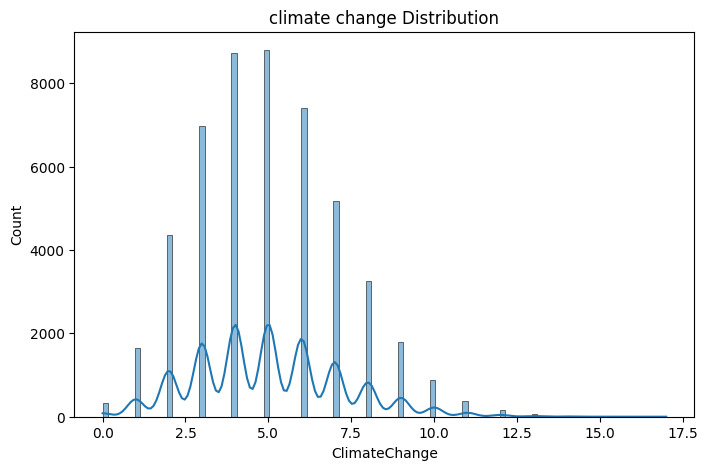

In [6]:
plt.figure(figsize=(8, 5))
sns.histplot(df['ClimateChange'], kde=True)
plt.title('climate change Distribution')
plt.show()

In [9]:
# Separate features (X) and target (y)
from sklearn.discriminant_analysis import StandardScaler



X = df.drop('FloodProbability', axis=1)
y = df['FloodProbability']
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Save scaler for API usage
joblib.dump(scaler, 'scalered.pkl')


['scalered.pkl']

In [10]:
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
linear = LinearRegression()
linear.fit(X_train, y_train)

# Predict and calculate MSE
y_pred_linear = linear.predict(X_test)
mse_linear = mean_squared_error(y_test, y_pred_linear)
print(f"Linear Regression MSE: {mse_linear}")

Linear Regression MSE: 1.0976013420018853e-31


In [14]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit ONLY on training data
X_test_scaled = scaler.transform(X_test)  # Transform test data with training scaler

In [15]:
# Split data AFTER fixing the leakage
from sklearn.linear_model import SGDRegressor
# train models
models = {
    'SGDRegressor': SGDRegressor(),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(random_state=42)
}

# Train and evaluate
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    results[name] = mse
    print(f'{name} MSE: {mse:.4f} R²: {r2:.4f}')

# Find best model
best_model_name = min(results, key=results.get)
print(f'\nBest Model: {best_model_name} with MSE: {results[best_model_name]:.4f}')
print(f"R²: {r2:.4f}")
print(f"MAE: {mae:.4f}")

SGDRegressor MSE: 0.0034 R²: -0.3606
DecisionTree MSE: 0.0022 R²: 0.1123
RandomForest MSE: 0.0007 R²: 0.7295

Best Model: RandomForest with MSE: 0.0007
R²: 0.7295
MAE: 0.0205


In [18]:
best_model = models[best_model_name]
joblib.dump(best_model, 'best_model.pkl')

['best_model.pkl']

In [19]:
# Load the best model
best_model = joblib.load('best_model.pkl')

# Assuming X_test is your test dataset
# Get a single data point from X_test
sample = X_test.iloc[[0]]  # First test row
prediction = best_model.predict(sample)

print(f"Predicted Flood Probability: {prediction[0]}")
print(f"Actual Flood Probability: {y_test.iloc[0]}")


Predicted Flood Probability: 0.4637499999999998
Actual Flood Probability: 0.455


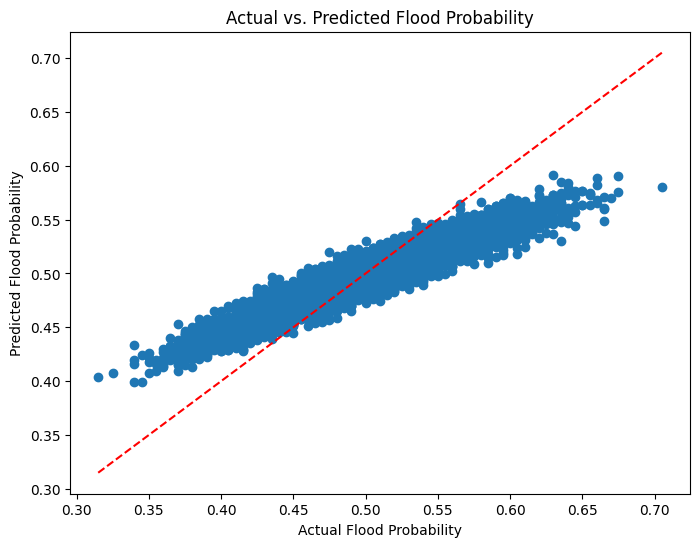

In [20]:
# Load the model
model = joblib.load('best_model.pkl')  # Replace with your model file


y_pred = model.predict(X_test)

# Create a scatter plot of actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Flood Probability")
plt.ylabel("Predicted Flood Probability")
plt.title("Actual vs. Predicted Flood Probability")

# Add the linear regression line
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Ideal line

plt.show()